In [80]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

In [41]:
EMPRESA = 'ITUB3.SA'

In [42]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    return data_hist

df = get_data_ticker(EMPRESA, '5y')
df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [43]:
adf_test = adfuller(df['Close'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.465152
p-value: 0.124185


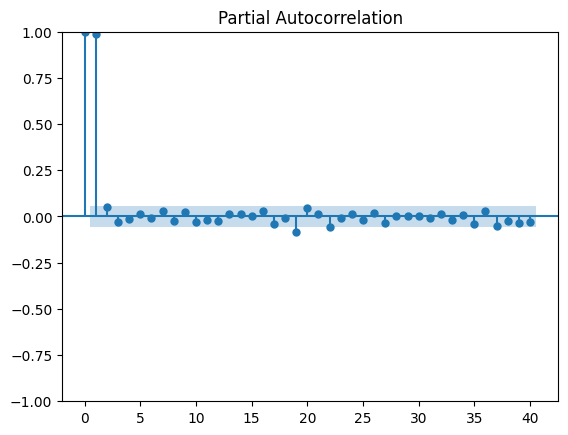

In [44]:
plot_pacf(df['Close'], lags=40)
plt.show()

### ARIMA na base pura

In [45]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

model_train = ARIMA(train['Close'], order=(0,2,1))
model_train_fit = model_train.fit()

test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(list(test_forecast.predicted_mean), index=test.index)

mse = mean_squared_error(test['Close'], test_forecast_series)
rmse = mse**0.5
print('RMSE:', rmse)

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

RMSE: 5.38934308608093


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


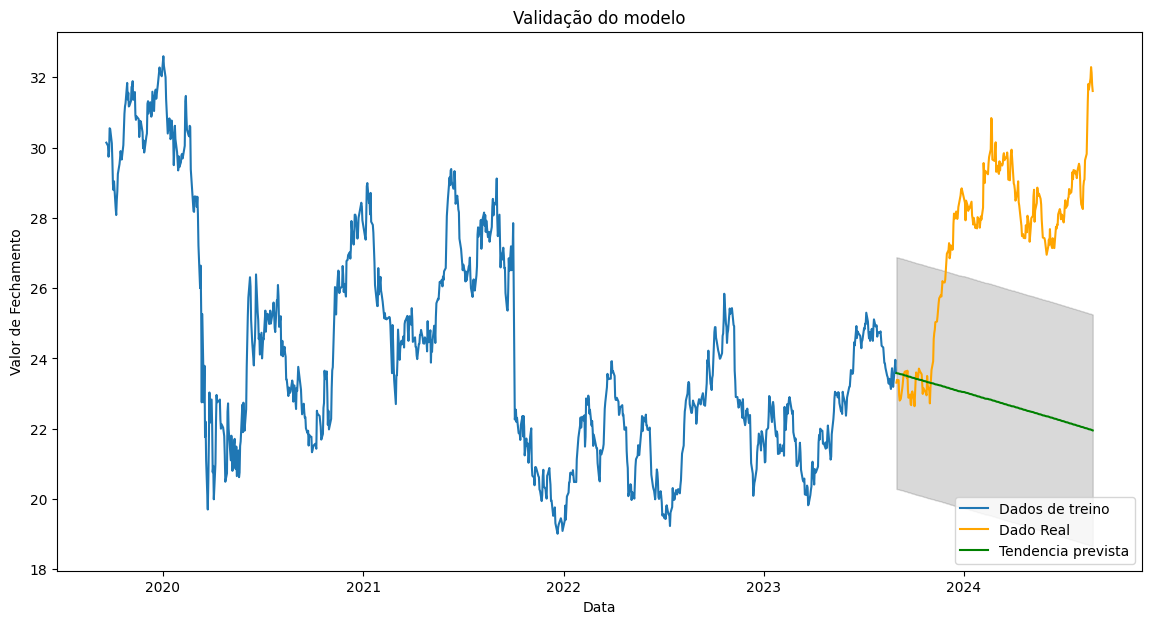

In [46]:
plt.figure(figsize=(14,7))
plt.plot(train['Close'], label='Dados de treino')
plt.plot(test['Close'], label='Dado Real', color='orange')
plt.plot(test_forecast_series, label='Tendencia prevista', color='green')
plt.fill_between(test.index, 
                 test_forecast_series + np.std(df)['Close'], 
                 test_forecast_series - np.std(df)['Close'], 
                 color='k', alpha=.15)
plt.title('Validação do modelo')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [47]:
model_train = ARIMA(df['Close'], order=(0,2,1))
model_train_fit = model_train.fit()

forecast = model_train_fit.get_forecast(steps=len(df))
forecast_series = pd.Series(list(forecast.predicted_mean), index=df.index)

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

### ARIMA na base estacionária

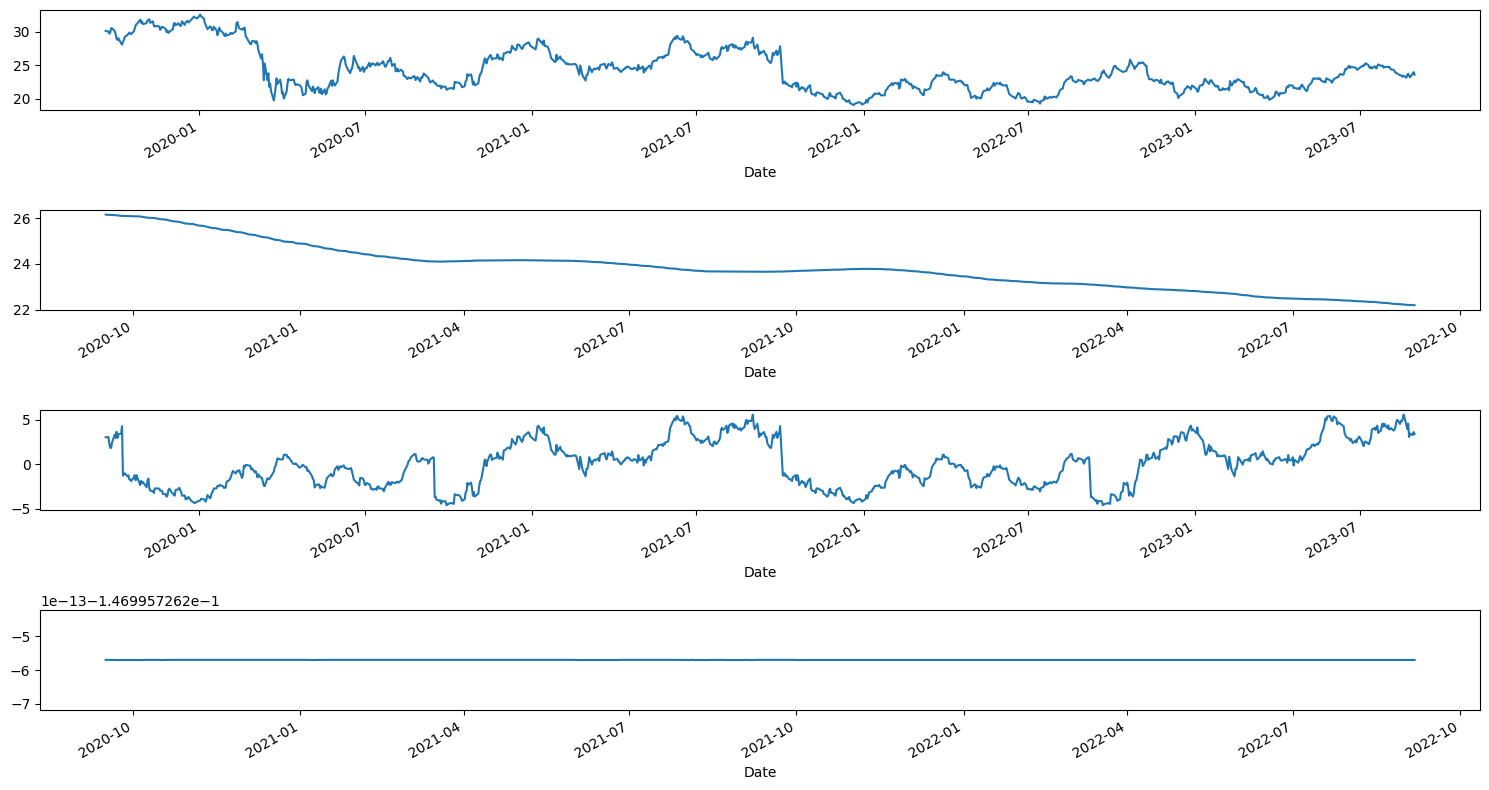

In [48]:
df = train["Close"]

result = sm.tsa.seasonal_decompose(df, period = int(len(df)/2))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

#### Média Móvel 15 dias

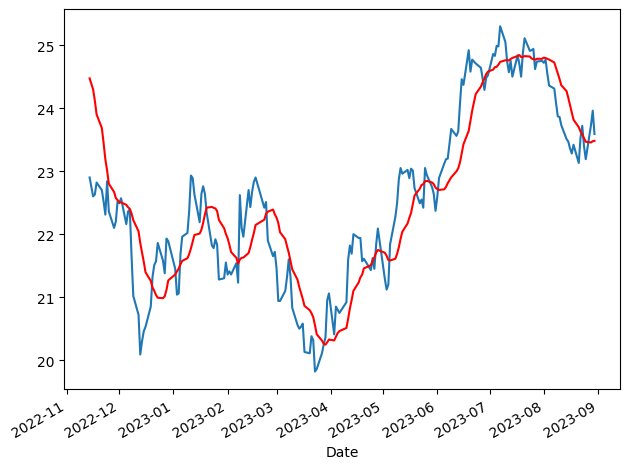

In [50]:
ma = df.rolling(15).mean()

fig, ax = plt.subplots()
df[-200:].plot(ax=ax, legend=False)
ma[-200:].plot(ax=ax, legend=False, color='r')
plt.tight_layout()

#### Log do df

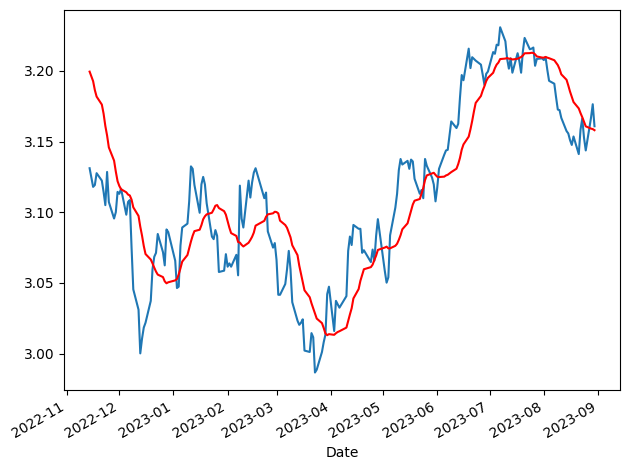

In [52]:
df_log = np.log(df)
ma_log = df_log.rolling(15).mean()

fig, ax = plt.subplots()
df_log[-200:].plot(ax=ax, legend=False)
ma_log[-200:].plot(ax=ax, legend=False, color='r')
plt.tight_layout()

#### Subtação do DF com a Média móvel + cálculo de desvio padrão

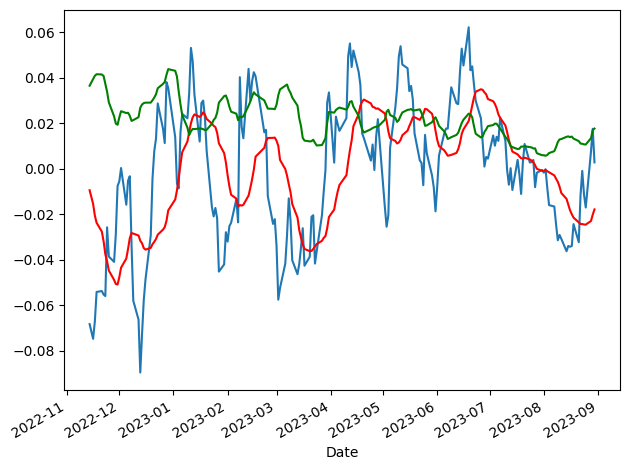

In [55]:
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(15).mean()
#desvio padrão
std_sub = df_sub.rolling(15).std()

fig, ax = plt.subplots()
df_sub[-200:].plot(ax=ax, legend=False)
ma_sub[-200:].plot(ax=ax, legend=False, color='r')
std_sub[-200:].plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#### ADF

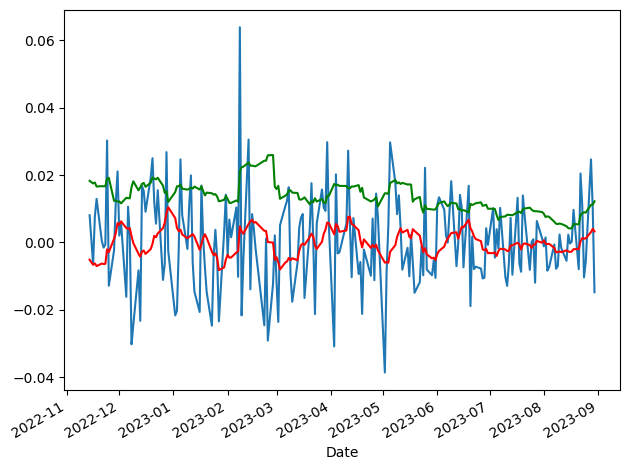

In [67]:
X_sub = df_sub.values
result_sub = adfuller(X_sub)

df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots()
df_diff[-200:].plot(ax=ax, legend=False)
ma_diff[-200:].plot(ax=ax, legend=False, color='r')
std_diff[-200:].plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X = df_diff.dropna().values

result_diff = adfuller(X)


#### Autocorrelação

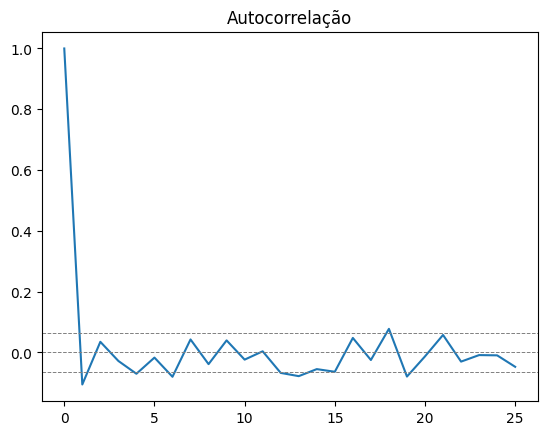

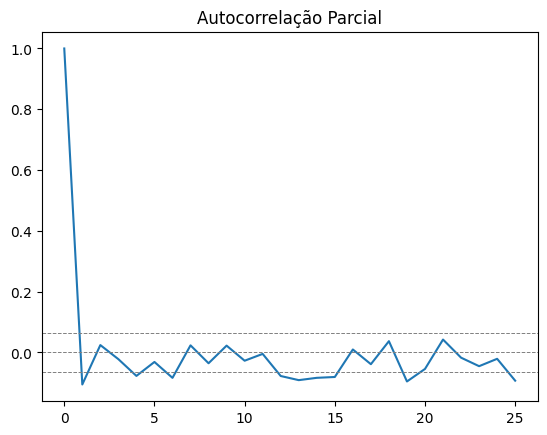

In [69]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

plt.plot(lag_acf)
plt.axhline(y=-1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=-1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação Parcial")
plt.show()

#### ARIMA

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

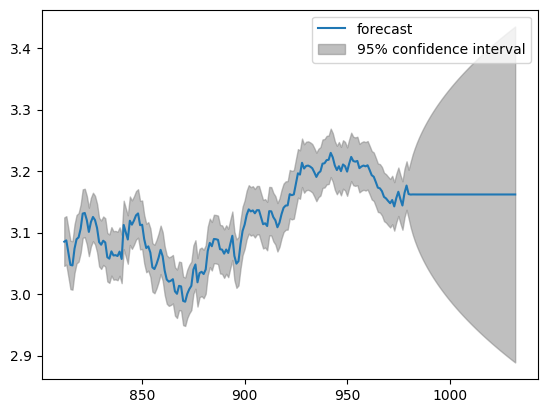

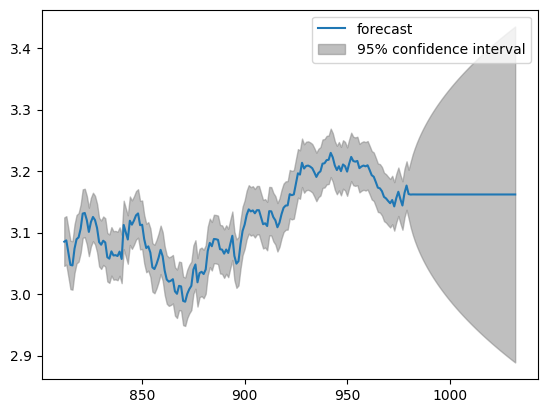

In [145]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

# Criando e ajustando o modelo ARIMA
model = ARIMA(df_log, order=(2,1,2))
result_AR = model.fit()

# Obtendo o número total de observações
n_obs = len(df_log)

# Plotando a previsão com índices numéricos
plot_predict(result_AR, start=n_obs-200, end=n_obs + 20)